# Swiss Roll Dataset

In [1]:
%load_ext autoreload

In [2]:
import os
import torch
import math
import numpy as np
import pyvista as pv
import seaborn as sns
import matplotlib.pyplot as plt

from pdmtut.datasets import SwissRoll
from regilib.core.dynamics.dynamical_state import DynamicalState

In [3]:
store_results = True

In [4]:
pv.set_plot_theme("document")

if store_results:
    result_save_path = '../../results/swiss_roll/dataset'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [5]:
dataset = SwissRoll(n_samples=100**2, seed=11)

In [6]:
(uniform_state, uniform_log_prob, uniform_index_colors), (
    uniform_ds_z, uniform_ds_u, uniform_ds_y) = dataset.sample_points_uniformly(n_samples=100**2, seed=11, return_intermediate_steps=True)

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
(sampled_state, sampled_log_prob, sampled_index_colors), (
    sampled_ds_z, sampled_ds_u, sampled_ds_y) = dataset.sample_points_randomly(n_samples=100**2, seed=11, return_intermediate_steps=True)

## Continuous Dataset

### Colored by density

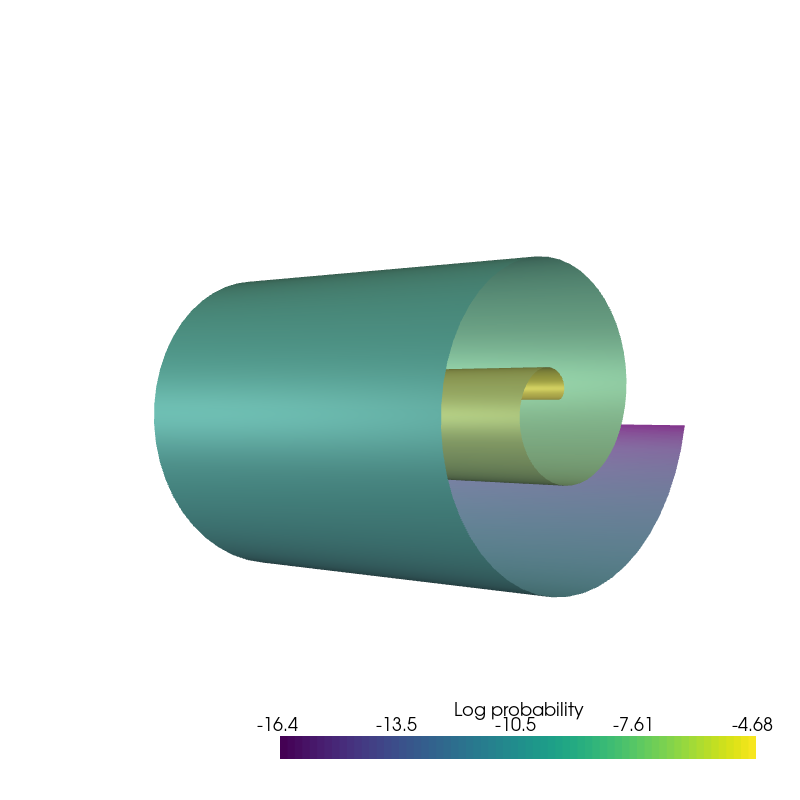

In [8]:
plotter = pv.Plotter()
plotter.add_mesh(
    pv.StructuredGrid(*uniform_state.view(100, 100, 3).permute(2, 0, 1).numpy()),
    scalars=uniform_log_prob, style='surface', pbr=True, metallic=0.2, roughness=0.6,
    scalar_bar_args={'title':'Log probability'}
)

plotter.add_light(pv.Light(
    position=(-65, 0, -65), show_actor=True, positional=True,
    cone_angle=100, intensity=2.))
plotter.add_light(pv.Light(
    position=(0, 0, -65), show_actor=True, positional=True,
    cone_angle=100, intensity=2.))
plotter.camera_position = [(-65, 0, 65), (0, 0, 0), (0, 1, 0)]
plotter.show(window_size=[800,800])
if result_save_path is not None: plotter.screenshot(os.path.join(result_save_path, 'continuous_density.png'))

### Colored by index

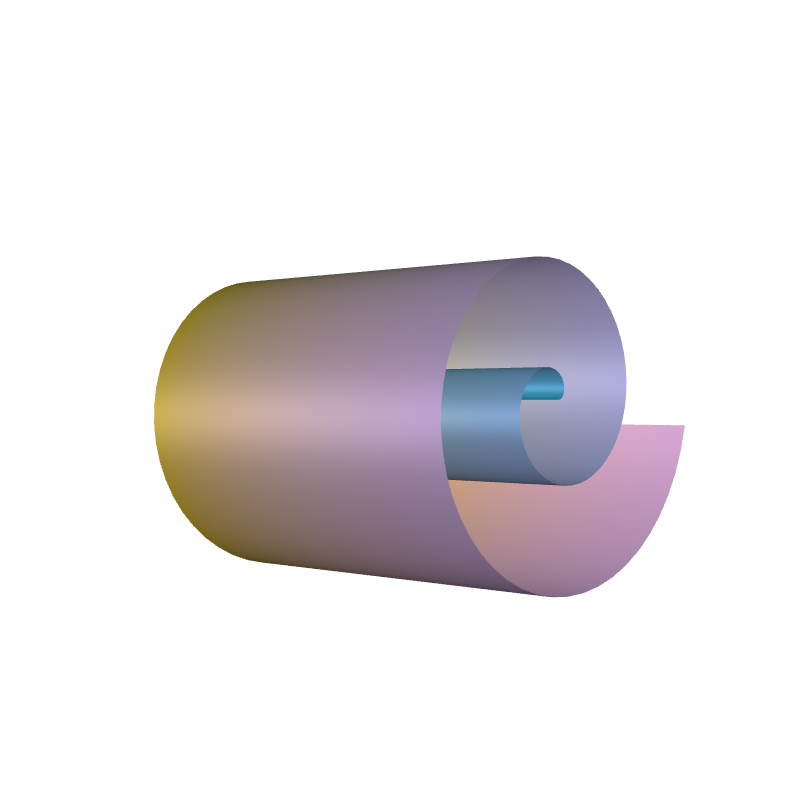

In [9]:
plotter = pv.Plotter()
plotter.add_mesh(
    pv.StructuredGrid(*uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy()),
    scalars=uniform_index_colors, style='surface',  pbr=True, metallic=0.2, roughness=0.6,
    rgb=True
)

plotter.add_light(pv.Light(
    position=(-65, 0, -65), show_actor=True, positional=True,
    cone_angle=100, intensity=2.))
plotter.add_light(pv.Light(
    position=(0, 0, -65), show_actor=True, positional=True,
    cone_angle=100, intensity=2.))
plotter.camera_position = [(-65, 0, 65), (0, 0, 0), (0, 1, 0)]
plotter.show(window_size=[800,800])
if result_save_path is not None: plotter.screenshot(os.path.join(result_save_path, 'continuous_index.png'))

## Input representation

In [10]:
from pdmtut.vis import plot_representation

In [11]:
z_coordinates = sampled_ds_z.state.detach()
z_extremes = dataset.z_extremes
z_extremes = torch.cat([z_extremes, z_extremes[[1,2]] + 1e-6*torch.randn(2, 2)]) # seaborn lineplot can not be perfectly vertical

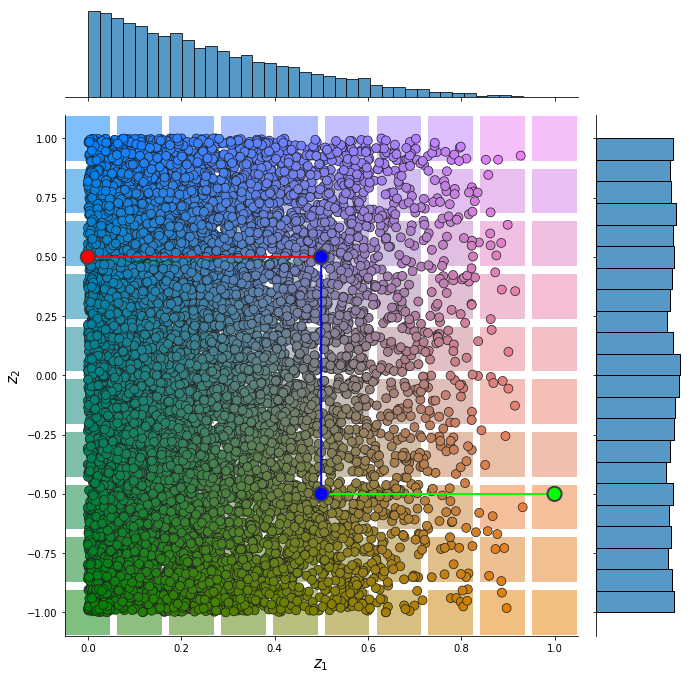

In [12]:
plot_representation(
    z_coordinates.numpy(), index_colors=sampled_index_colors, z_extremes=z_extremes, 
    interpolate_background=True, root=result_save_path
)

In [13]:
import math
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import seaborn as sns
import torch

def _plot_representation_2d(
        z_coordinates, index_colors=None, z_extremes=None,
        interpolate_background=False, root=None, axis=None):

    data = {
        '$z_1$' : z_coordinates[:, 0],
        '$z_2$' : z_coordinates[:, 1]
    }

    # distribution plot
    g = sns.jointplot(
        data=data, x="$z_1$", y="$z_2$", zorder=100, s=80, edgecolor="#202020",
        joint_kws={'color':None, 'c':index_colors.tolist()},
        ax=axis
    )
    g.fig.set_figwidth(10); g.fig.set_figheight(10)
    g.ax_joint.set_xlabel('$z_1$', fontsize=15)
    g.ax_joint.set_ylabel('$z_2$', fontsize=15)

    # interpolate background
    if interpolate_background and index_colors is not None:
        from scipy.interpolate import NearestNDInterpolator

        z_range = (np.floor(z_coordinates.min(0)),
                   np.ceil(z_coordinates.max(0)))

        X, Y = np.meshgrid( # 2D grid for interpolation
            np.linspace(z_range[0][0], z_range[1][0], 10),
            np.linspace(z_range[0][1], z_range[1][1], 10),
        )

        interp = NearestNDInterpolator(z_coordinates, y=index_colors)
        Z = interp(X, Y)

        g.ax_joint.scatter(
            X.flatten(), Y.flatten(), c=Z.reshape(-1, 3),
            linewidth=0., marker='s', s=2000, alpha=0.5)

    # plot extreme points and trajectories
    if z_extremes is not None:
        n_sets = math.floor(z_extremes.shape[0] / 2)
        extreme_data = {
            '$z_1$': z_extremes[:, 0],
            '$z_2$': z_extremes[:, 1],
            'set': torch.cat([n*torch.ones(2) for n in range(n_sets)])
        }

        # plot extreme points
        sns.scatterplot(
            data=extreme_data, x='$z_1$', y='$z_2$', hue='set', legend=False,
            s=200, linewidth=2, ax=g.ax_joint, zorder=200, edgecolor="#404040",
            palette=[(1., 0., 1.), (0., 1, 0.)]
        )

        # plot line between extreme points 1
        sns.lineplot(
            data=extreme_data, x='$z_1$', y='$z_2$', hue='set',
            lw=2, ax=g.ax_joint, zorder=100, legend=False,
            palette=[(1., 0, 1.), (0., 1, 0.)]
        )

        if axis is None: plt.show()


## Input Reconstruction

In [14]:
from pdmtut.vis import plot_reconstruction

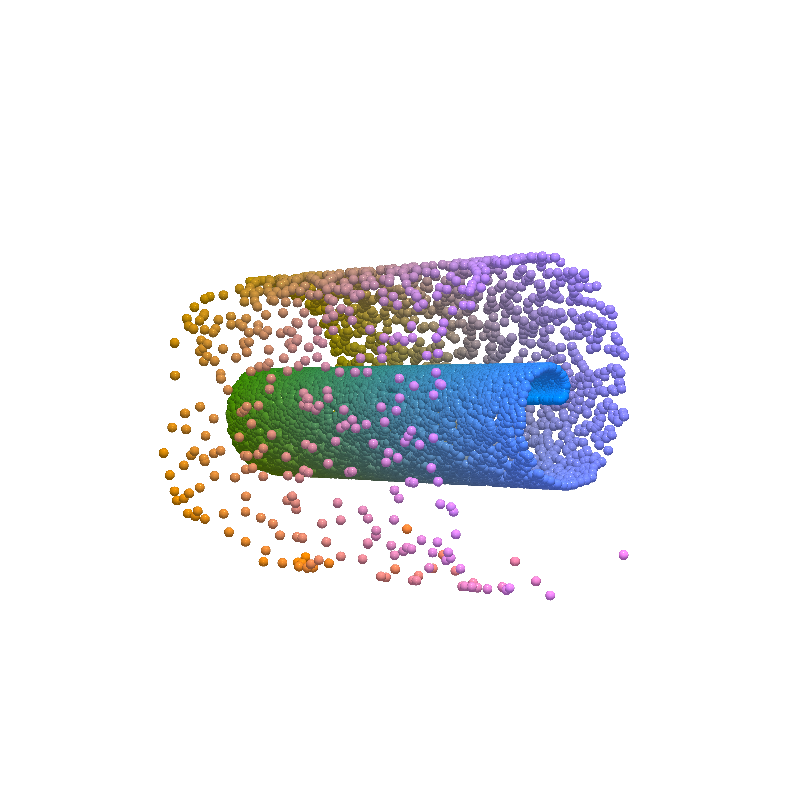

In [15]:
plot_reconstruction(
    sampled_state.numpy(), sampled_index_colors, root=result_save_path
)

## Density Estimation

In [16]:
from pdmtut.vis import plot_density

In [17]:
sampled_log_prob.mean()

tensor(-6.3357)

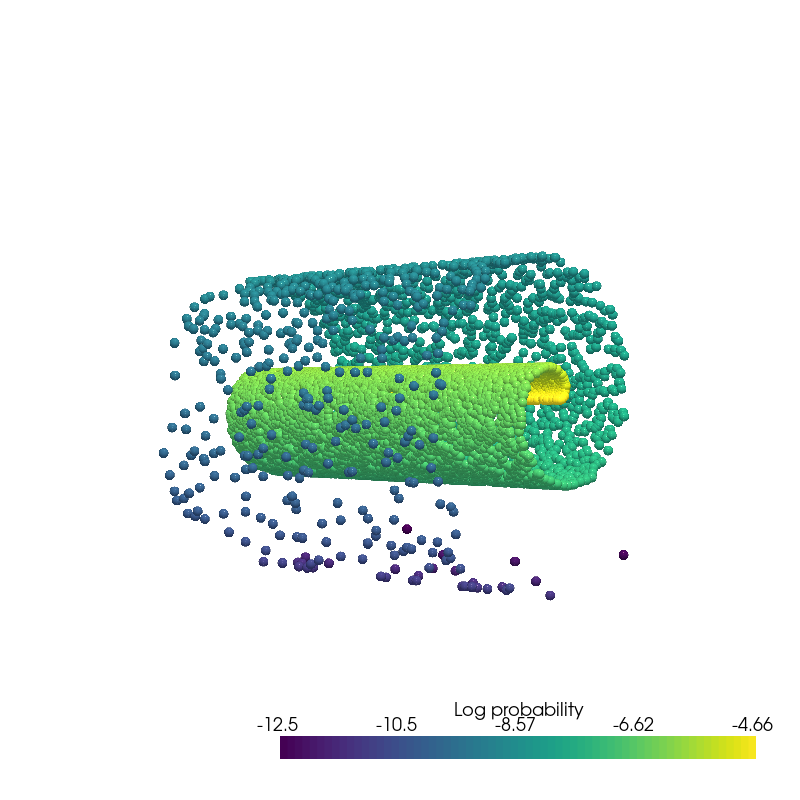

In [18]:
plot_density(sampled_state.numpy(), sampled_log_prob.numpy(), root=result_save_path)

## Interpolation

In [19]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

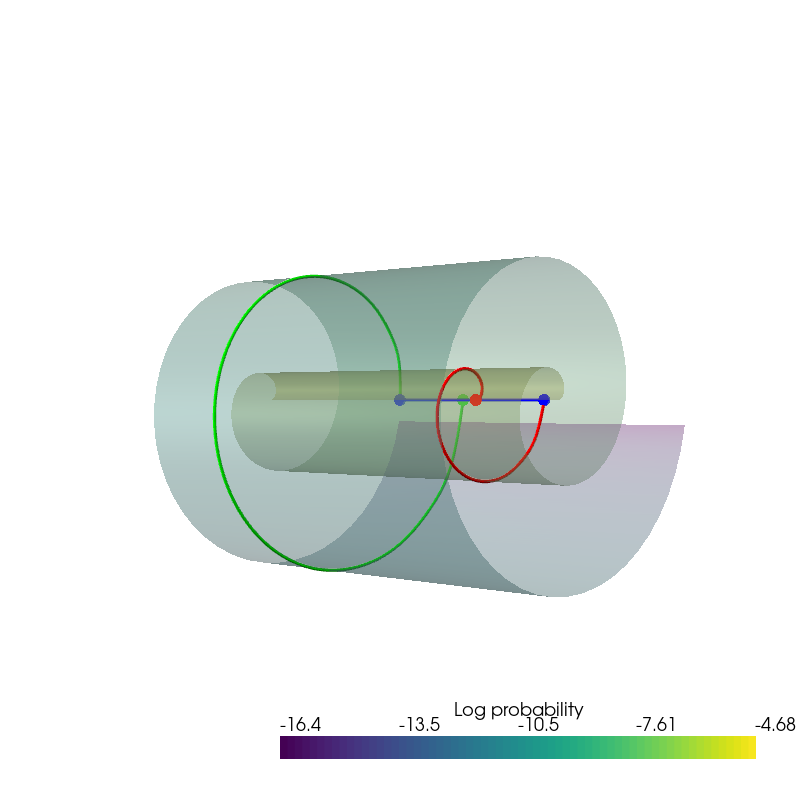

In [20]:
linfit1 = interp1d([1,20], z_extremes[[0,1]].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[[2,3]].numpy(), axis=0)
linfit3 = interp1d([1,20], z_extremes[[1,2]].numpy(), axis=0)

interpolated_points_1, _, _ = dataset.gen_data_from_initial_tensor(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2, _, _ = dataset.gen_data_from_initial_tensor(torch.Tensor(linfit2(np.arange(1,21))))
interpolated_points_3, _, _ = dataset.gen_data_from_initial_tensor(torch.Tensor(linfit3(np.arange(1,21))))

plot_interpolation(
    interpolated_points_1.numpy(), interpolated_points_2.numpy(), interpolated_points_3.numpy(),
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(), 
    mesh_log_prob=uniform_log_prob, root=result_save_path
)